In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import os
import matplotlib.image as mpimg
from PIL import Image

In [4]:
train_dir = '/content/drive/My Drive/Zindi_Tuberculosis_Classification/train_small/train_small'
#test_dir = '/content/drive/My Drive/Zindi/test/'

In [5]:

categories = ['0','1']

In [6]:
#from keras.applications import *
#conv_base=Xception(input_shape = (299,229,3),weights='imagenet',include_top=False,pooling='avg')

In [7]:
#from keras.preprocessing.image import ImageDataGenerator
#from keras.applications.vgg16 import VGG16

#conv_base = VGG16(weights = 'imagenet',include_top = False,input_shape = (128,128,3))
##conv_base.summary()

In [8]:
#  from keras.applications.vgg19 import VGG19
#conv_base= VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")
#conv_base.summary()

In [9]:
#from keras.preprocessing.image import ImageDataGenerator
#from keras.applications.vgg16 import VGG16

#conv_base = VGG16(weights = 'imagenet',include_top = False,input_shape = (224,224,3))
#conv_base.summary()

In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
conv_base=MobileNetV2(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
conv_base.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [11]:
for layer in conv_base.layers:
	layer.trainable = False

In [12]:

from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential
from keras import layers,models,optimizers 
# Although this part can be done also with the functional API, I found that for this simple models, this becomes more intuitive
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation="softmax")) # Finally our activation layer! we use 10 outputs as we have 3 covid case(covid normal varial pnemoniea ) (labels)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dropout (Dropout)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               32113152  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 34,372,162
Trainable params: 32,114,178
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
from keras import optimizers
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001)
learning_rate = 1e-3

checkpoint = ModelCheckpoint("Tuberculosis_MobileNetV2.h5", monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate, clipnorm = 1.), metrics = ['acc'])

In [14]:
from keras.preprocessing.image import ImageDataGenerator

LR = 1e-5
height=224
width=224
channels=3
seed=1337
batch_size = 64 #Number of images to load at each iteration
num_classes = 3
epochs = 10
data_augmentation = True
num_predictions = 20# Training generator
#train_datagen = ImageDataGenerator(
 #       validation_split=0.20
   #     rescale=1./255,
  #      rotation_range=40,
    #    shear_range=0.2,
     #   zoom_range=0.2,
      #  horizontal_flip=True,
       # )

#train_generator = train_datagen.flow_from_directory(train_dir, 
 #                                                   target_size=(256,256),
  #                                                  batch_size=64,
   #                                                 class_mode='categorical')

# Test generator
#validation_generator = ImageDataGenerator(rescale=1./255)
#validation_generator = validation_generator.flow_from_directory(test_dir, 
 #                                                    target_size=(256,256),
 #                                                    batch_size=64,
  #                                                   class_mode='categorical')

#test_datagen = ImageDataGenerator(rescale=1./255)
#test_generator = test_datagen.flow_from_directory(test_dir, 
 #                                                 target_size=(height,width), 
 #                                                 batch_size=batch_size,
 #                                                 seed=seed,
  #                                                shuffle=False,
   #                                               class_mode='categorical')


# Validation ImageDataGenerator with rescaling.
valid_datagen = ImageDataGenerator(rescale=1./255)
# Training ImagaDataGenerator with Augmentation transf.  
#train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,\
#                                   rotation_range=40, shear_range=10,\
#                                   zoom_range=0.1, fill_mode='nearest', \
#                                   height_shift_range=0.05, width_shift_range=0.1)

# Create a flow from the directory for validation data - seed=42
# Choose subset = 'validation'
train_datagen = ImageDataGenerator(rescale=1./255,
        
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
    validation_split=0.3) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    shuffle=True,
    seed=seed,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(224, 224),
    shuffle=False,
    seed=seed,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data


train_num = train_generator.samples
validation_num = validation_generator.samples
validation_num

Found 504 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


214

In [15]:
sample_training_images, _ = next(train_generator)

In [16]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

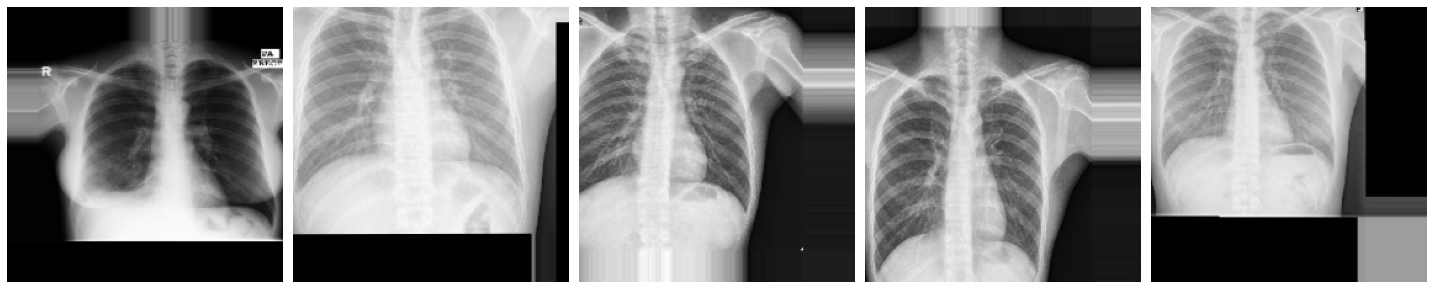

In [17]:
plotImages(sample_training_images[:5])

In [18]:
model_history = model.fit(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps= validation_num // batch_size,
                             callbacks=[checkpoint], 
                              verbose = 1)

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 26.9044 - acc: 0.5545 
Epoch 00001: val_acc improved from -inf to 0.64062, saving model to Tuberculosis_MobileNetV2.h5
7/7 [==============================] - 474s 68s/step - loss: 26.9044 - acc: 0.5545 - val_loss: 1.3473 - val_acc: 0.6406
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 0.8974 - acc: 0.7227
Epoch 00002: val_acc improved from 0.64062 to 0.77604, saving model to Tuberculosis_MobileNetV2.h5
7/7 [==============================] - 14s 2s/step - loss: 0.8974 - acc: 0.7227 - val_loss: 0.5733 - val_acc: 0.7760
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 0.6727 - acc: 0.7273
Epoch 00003: val_acc improved from 0.77604 to 0.78646, saving model to Tuberculosis_MobileNetV2.h5
7/7 [==============================] - 14s 2s/step - loss: 0.6727 - acc: 0.7273 - val_loss: 0.4758 - val_acc: 0.7865
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 0.4688 - acc: 0.8058
Ep

In [19]:
  path='/content/drive/My Drive/Model_save/Tuberculosis__MobileNetV2_224_X_224.h5'
model.save(path)

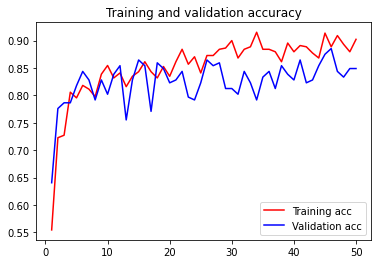

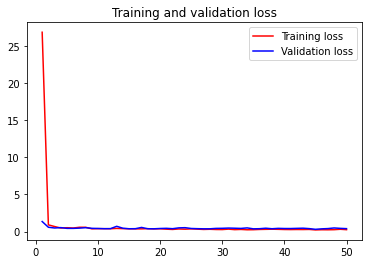

In [20]:
#Plot Training and validation accuracy and Training and validation loss
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [21]:
Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_pred
#validation_generator.classes

Instructions for updating:
Please use Model.predict, which supports generators.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1])

In [22]:
validation_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [23]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn import metrics
accuracy = accuracy_score(validation_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 81.3% 


In [24]:
print(metrics.classification_report(validation_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       109
           1       0.85      0.75      0.80       105

    accuracy                           0.81       214
   macro avg       0.82      0.81      0.81       214
weighted avg       0.82      0.81      0.81       214



In [ ]:
from keras.models import load_model
import cv2
from keras.preprocessing import image
import numpy as np
from keras import optimizers
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001)
test_data=[]
model_deploy = load_model('/content/drive/My Drive/Model_save/Tuberculosis_VGG16_3_224_X_224.h5')

categories = ['0','1']
test_gen = '/content/drive/My Drive/Zindi_Tuberculosis_Classification/test_small/test_small'
for i in os.listdir(test_gen):
  test_data.append(i)
df=pd.DataFrame(test_data)



In [ ]:
df[0].count()

82

In [ ]:
test_data_1=[]
pred_1=[]
test_data=[]
for imagePath in os.listdir(test_gen):
  fullpath = os.path.join(test_gen,imagePath) 
  test_data_1.append(fullpath)
  test_image_o = cv2.imread(fullpath) 
  test_image=cv2.resize(test_image_o,(224,224))# .flatten()
  test_data_2=np.array(test_image,dtype="float")/255.0
  test_data_2=test_data_2.reshape([-1,224,224, 3])
  #test_data_2.append(test_data_2)
  # scale the raw pixel intensities to the range [0, 1]
  #conf=max(model_deploy.predict(np.random.rand(1, 224,224, 3))[0])
  #conf="{:.2f}".format(conf*100)
  pred = model_deploy.predict(test_data_2)
  predictions =np.argmax(pred, axis=1) # return to label
  #pred_1.append(predictions[0])
  test_data.append(fullpath+'/'+str([predictions[0]]))

In [ ]:
df=pd.DataFrame({'Path':test_data})
df.head()

,Path
0,/content/drive/My Drive/Zindi_Tuberculosis_Cla...
1,/content/drive/My Drive/Zindi_Tuberculosis_Cla...
2,/content/drive/My Drive/Zindi_Tuberculosis_Cla...
3,/content/drive/My Drive/Zindi_Tuberculosis_Cla...
4,/content/drive/My Drive/Zindi_Tuberculosis_Cla...


In [ ]:
df.to_csv("output.csv")

In [ ]:
from google.colab import files
files.download("output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
 join_1=[]
for k, category in enumerate(categories):
  for f in os.listdir(test_data_1):
    join_1.append([test_data_1+category+'/'+f, k])

TypeError: ignored

In [ ]:
print(join)

NameError: ignored